#### Universal ELO Model

In this notebook, we try to create a universal ELO model, a la 538.

In [1]:
import os
import pandas as pd
from tennis_new.fetch.defs import STORED_DATA_PATH

#### Mess Around With Data

In [2]:
jd = pd.read_csv(
    os.path.join(STORED_DATA_PATH, 'joined.tsv'),
    sep='\t'
)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,6,33,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ELO_REL_COLUMNS = [
    'match_id',
    'winner_name',
    'loser_name',
    'winner_player_id',
    'loser_player_id',
    'tourney_surface',
    'tourney_year',
    'tourney_month',
    'tourney_day',
    'round_order',
    'match_order',
    'tourney_round_name',
    'tourney_name'
]
jd[ELO_REL_COLUMNS].head()

,match_id,winner_name,loser_name,winner_player_id,loser_player_id,tourney_surface,tourney_year,tourney_month,tourney_day,round_order,match_order,tourney_round_name,tourney_name
0,2016-451-d643-n409,b'Novak Djokovic',b'Rafael Nadal',d643,n409,Hard,2016,1.0,4.0,1,1,Finals,Brisbane
1,2016-451-d643-ba47,b'Novak Djokovic',b'Tomas Berdych',d643,ba47,Hard,2016,1.0,4.0,2,1,Semi-Finals,Brisbane
2,2016-451-n409-me89,b'Rafael Nadal',b'Illya Marchenko',n409,me89,Hard,2016,1.0,4.0,2,2,Semi-Finals,Brisbane
3,2016-451-d643-md56,b'Novak Djokovic',b'Leonardo Mayer',d643,md56,Hard,2016,1.0,4.0,3,1,Quarter-Finals,Brisbane
4,2016-451-n409-kb54,b'Rafael Nadal',b'Andrey Kuznetsov',n409,kb54,Hard,2016,1.0,4.0,3,2,Quarter-Finals,Brisbane


In [4]:
# Sort data so we can update appropriately
# TODO: This should be done in the creation of the joined?
jd.sort_values(
    ['tourney_year', 'tourney_month', 'tourney_day', 'round_order', 'match_order'],
    ascending=[True, True, True, False, True],
    inplace=True
)
jd[ELO_REL_COLUMNS].head()

,match_id,winner_name,loser_name,winner_player_id,loser_player_id,tourney_surface,tourney_year,tourney_month,tourney_day,round_order,match_order,tourney_round_name,tourney_name
13791,1877-540-e994-lh24,L. Erskine,J. Lambert,e994,lh24,Grass,1877,7.0,9.0,4,1,Round Robin,Wimbledon
13792,1877-540-gi91-hg46,Spencer Gore,M. Hankey,gi91,hg46,Grass,1877,7.0,9.0,4,2,Round Robin,Wimbledon
13793,1877-540-lh23-bt10,F. Langham,J. Baker,lh23,bt10,Grass,1877,7.0,9.0,4,3,Round Robin,Wimbledon
13794,1877-540-mu62-af58,William Marshall,B. Akroyd,mu62,af58,Grass,1877,7.0,9.0,4,4,Round Robin,Wimbledon
13795,1877-540-mu66-o628,J. Marshall,F. Oliver,mu66,o628,Grass,1877,7.0,9.0,4,5,Round Robin,Wimbledon


In [5]:
from tennis_new.ml.elo import ELOModel

elo = ELOModel(winner_mod=True)
elo.fit_and_backfill(
    jd['winner_name'].tolist(),
    jd['loser_name'].tolist(),
    jd['match_id'].tolist()
)

In [6]:
elo_preds = pd.DataFrame(elo.history)

In [7]:
together = pd.merge(
    jd,
    elo_preds,
    on='match_id'
)

In [8]:
# Top player-years of all-time
together.sort_values('elo1', ascending=False).drop_duplicates(['winner_name', 'tourney_year'])[[
    'winner_name', 'elo1', 'tourney_year'
]].head(20)

,winner_name,elo1,tourney_year
184275,Novak Djokovic,2598.207088,2015
178627,Novak Djokovic,2547.730451,2014
174918,Rafael Nadal,2525.219964,2013
172149,Novak Djokovic,2522.606206,2013
74187,John McEnroe,2519.516093,1985
73203,John McEnroe,2517.241843,1984
145086,Roger Federer,2514.054465,2007
58319,Bjorn Borg,2511.026926,1980
175833,Rafael Nadal,2509.019155,2014
166467,Novak Djokovic,2505.620223,2011


In [9]:
# Look at hold-out performance
test = together[
    (together['tourney_year'] > 2010)
]
test['tourney_year'].value_counts()

2012    4496
2011    4489
2015    4443
2013    4439
2014    4350
2016    4022
2017    3962
2018    3954
2019    1848
Name: tourney_year, dtype: int64

In [10]:
(test['elo_match_prediction'] > 0.5).mean()

0.6505291225731189

65% accuracy since 2010

In [11]:
MAJORS = [
    'Wimbledon',
    'US Open',
    'Roland Garros',
    'Australian Open'
]

major_test = test[
    (test['tourney_name'].isin(MAJORS)) &
    (test['elo_match_prediction'] != 0.5)
]
major_test.groupby(['tourney_name', 'tourney_year']).apply(
    lambda x: (
        (x['elo_match_prediction'] > 0.5).mean(),
        x.shape[0]
    )
)

tourney_name     tourney_year
Australian Open  2011            (0.7112970711297071, 239)
                 2012            (0.6861924686192469, 239)
                 2013            (0.7071129707112971, 239)
                 2014            (0.6764705882352942, 238)
                 2015             (0.702928870292887, 239)
                 2016            (0.5329949238578681, 197)
Roland Garros    2011            (0.6861924686192469, 239)
                 2012             (0.702928870292887, 239)
                 2013            (0.6932773109243697, 238)
                 2014            (0.6485355648535565, 239)
                 2015            (0.6820083682008368, 239)
                 2016            (0.6302521008403361, 238)
US Open          2011            (0.6778242677824268, 239)
                 2012            (0.6820083682008368, 239)
                 2013            (0.6610878661087866, 239)
                 2014            (0.6276150627615062, 239)
                 2015     

What's going on in 2016?

In [12]:
test[
    (test['tourney_name'] == 'Australian Open') &
    (test['tourney_year'] == 2016)
][['winner_name', 'loser_name', 'elo1', 'elo2', 'elo_match_prediction', 'winner_seed', 'loser_seed']]

,winner_name,loser_name,elo1,elo2,elo_match_prediction,winner_seed,loser_seed
184487,b'Daniel Evans',b'Luca Vanni',1500.000000,1504.618277,0.493354,NaN,1
184488,b'Ruben Bemelmans',b'Harry Bourchier',1434.336805,1500.000000,0.406612,2,WC
184489,b'Tim Smyczek',b'Jose Pereira',1504.618277,1500.000000,0.506646,3,NaN
184490,b'Alejandro Falla',b'Daniel Nguyen',1500.000000,1500.000000,0.500000,4,NaN
184491,b'Jan-Lennard Struff',b'Hans Podlipnik-Castillo',1434.336805,1434.336805,0.500000,5,NaN
184492,b'Lorenzo Giustino',b'Lukas Lacko',1500.000000,1504.618277,0.493354,NaN,6
184493,b'Aleksandr Nedovyesov',b'Marsel Ilhan',1500.000000,1434.336805,0.593388,NaN,7
184494,b'Go Soeda',b'Maximilian Marterer',1500.000000,1548.037155,0.431306,8,NaN
184495,b'Michael Berrer',b'Tristan Lamasine',1504.618277,1500.000000,0.506646,9,NaN
184496,b'Radu Albot',b'Jan Mertl',1504.618277,1500.000000,0.506646,10,NaN


#### Look at Players over Time

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

elo_preds['tourney_year'] = jd['tourney_year']
elo_preds['tourney_month'] = jd['tourney_month']
elo_preds['tourney_day'] = jd['tourney_day']

def plot_player_over_time(pid):
    rel = elo_preds[
        (elo_preds['p1_id'] == pid) | (elo_preds['p2_id'] == pid)
    ]
    print(rel['tourney_year'].max())
    elos = rel[[
        'p1_id',
        'p2_id',
        'elo1',
        'elo2'
    ]].apply(
        lambda x: x['elo1'] if x['p1_id'] == pid else x['elo2'],
        axis=1
    )
    plt.plot(range(len(elos)), elos)
    _x = np.array(range(0, len(elos), 50))
    plt.xticks(
        _x.tolist(),
        rel['tourney_year'].iloc[_x].tolist(),
        rotation=90
    )

nan


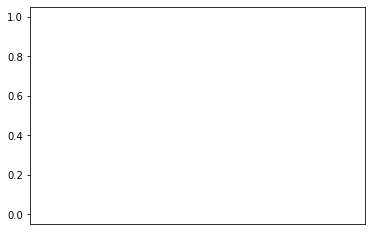

In [14]:
plot_player_over_time(b'Roger Federer')

TODO: There is some shit going on with bytes and strings and such...need to figure this out...